# Adaptive RAG
Framework that dynamically adjusts its stratergy to handling queries based on their complexity.<br>
It is like having a smart assistant that knows when to dig deep for information and when to provide a simple answer.<br>
Instead of single and rigid approach, it chooses the most appropriate retrieval method for each query.

### Major Components:
1. **Query Analysis**: Take a question and based on the question, try to route it to a specific router (web search, retriever, etc.)

2. **Self-corrective RAG**: Advanced RAG that has improved accuracy and relevance.

In [157]:
import os
from dotenv import load_dotenv
load_dotenv() ## aloading all the environment variable

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["MISTRAL_API_KEY"]=os.getenv("MISTRAL_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [158]:
### Retriever

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_mistralai import MistralAIEmbeddings

### from langchain_cohere import CohereEmbeddings

# Set embeddings
embd = MistralAIEmbeddings()

# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorstore
vectorstore=FAISS.from_documents(
    documents=doc_splits,
    embedding=MistralAIEmbeddings()
)


retriever=vectorstore.as_retriever()

d:\HCL Tech\Udemy\Gen AI\venv\Lib\site-packages\langchain_mistralai\embeddings.py:181: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  warnings.warn(


In [159]:
# Router
from typing_extensions import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field

class route_query(BaseModel):
    """Route user query to most suitable data source."""
    data_source: Literal["vector_store", "web_search",] = Field(description="Given a user question, choose to route it to either 'vector_store' or 'web_search'")

llm = ChatGroq(model = "gemma2-9b-it")
router_llm = llm.with_structured_output(route_query)

router_prompt = ChatPromptTemplate.from_messages([
    ( "system","""
                You are an expert at routing a user question to a vector_store or web_search.              
                The vector_store contains documents related to agents, prompt engineering and adversarial attacks.
                Use the vector_store for questions on these topics. Otherwise, use web_search.
    """),
    ("human", "Question: {question}",)
])
question_router = router_prompt | router_llm


In [160]:
temp = question_router.invoke({"question":"What is average height of a human."})
temp.data_source

'web_search'

In [161]:
question_router.invoke({"question":"What is Agentic AI."}).data_source
# the router is working perfectly

'vector_store'

In [164]:
# Document Grader

class gradescore(BaseModel):
    """Binary score for relevance check on retrieved documents"""
    score: Literal["relevant", "irrelevant"] = Field(description="Whether the documents are 'relevant' to the query or 'irrelevant'")

llm = ChatGroq(model= "gemma2-9b-it")
grader_llm = llm.with_structured_output(gradescore)

grader_prompt = ChatPromptTemplate.from_messages([
    ( "system","""
     You are a grader assessing relevance of a retrieved document to a user question. 
     If the document contains keyword(s) or semantic meaning related to the question, score it as relevant. 
     Give a binary score 'relevant' or 'irrelevant' score to indicate whether the document is relevant to the question or not.
    """),
    ("human", "Retrieved Document:\n\n{documents} \n\nQuestion: {question}",)
])

document_grader = grader_prompt | grader_llm

In [165]:
question = "prompt engineering"
temp_docs = retriever.invoke(question)
document_grader.invoke({"documents":temp_docs, "question":question})

gradescore(score='relevant')

In [166]:
question = "Guard Dogs"
temp_docs = retriever.invoke(question)
document_grader.invoke({"documents":temp_docs, "question":question})
# the grader is working perfectly

gradescore(score='irrelevant')

In [167]:
# Generator
from langchain_core.output_parsers import StrOutputParser

generator_prompt = ChatPromptTemplate.from_messages([
    ("system", "Answer the question that user asks based on the context provided."),
    ("human", "Context: \n{documents}\n\n Question: \n{question}")
])

generator = generator_prompt | llm | StrOutputParser()

In [168]:
temp = generator.invoke({"documents":temp_docs, "question":"what is prompt engineering?"})
print(temp)
# generator works well

While the provided text focuses on adversarial attacks against LLMs, it does touch upon prompt engineering in passing. 

Here's what we can infer about prompt engineering from the context:

* **It's related to how LLMs understand and respond to input:** The text mentions "in-context learning" as an example of short-term memory used by LLMs. Prompt engineering likely involves carefully crafting these input "prompts" to guide the LLM's response in a desired direction.
* **It's crucial for controlling LLM output:** The text states that "attacking LLMs is essentially to control the model to output a certain type of (unsafe) content." This implies that  prompt engineering can be used not only for beneficial purposes but also for malicious ones.


Essentially, **prompt engineering is the art and science of designing effective inputs (prompts) for LLMs to elicit the desired output.** It involves understanding how LLMs process language and using that knowledge to craft prompts that are clear, 

In [169]:
# Hallucination Checker

class grounded(BaseModel):
    """Binary score for hallucination present in generation"""
    score: Literal["not_hallucinating", "hallucinating"] = Field(description="Whether the generation is grounded in the facts ,i.e. not_hallucinating,  or it is not grounded in the facts, i.e. hallucinating.")

llm = ChatGroq(model= "gemma2-9b-it")
hallucination_checker_llm = llm.with_structured_output(grounded)

hallucination_checker_prompt = ChatPromptTemplate.from_messages([
    ( "system","""
     You are a grader assessing whether an LLM generation is grounded in/ supported by a set of retrieved facts. 
     Give a binary score 'hallucinating' or 'not_hallucinating' to indicate whether the generation is grounded in/ supported by the facts.
    """),
    ("human", "Set of facts:\n\n{documents} \n\n LLM Generation: {generation}",)
])

hallucination_checker = hallucination_checker_prompt | hallucination_checker_llm

In [170]:
hallucination_checker.invoke({"documents":temp_docs, "generation":temp})
# hallucination checker works good

grounded(score='not_hallucinating')

In [171]:
# Answer Grader

class answerscore(BaseModel):
    """Binary score to check if answer addresses question"""
    score: Literal["addresses", "ignores"] = Field(description="Whether the answer 'addresses' the question or 'ignores' it")

llm = ChatGroq(model= "gemma2-9b-it")
answer_grader_llm = llm.with_structured_output(answerscore)

answer_grader_prompt = ChatPromptTemplate.from_messages([
    ( "system","""
     You are a grader assessing whether an answer addresses/resolves a question or not. 
     Give a binary score 'addresses' or 'ingores'. 'addresses' means the answer resolves the question, 'ignores' if otherwise.
    """),
    ("human", "Question:\n\n{question} \n\n Answer: {generation}",)
])

answer_grader = answer_grader_prompt | answer_grader_llm

In [172]:
#Question Rewriter

question_rewriter_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", """
         You are a rephrasing assistant. Your only job is to rephrase the following question without changing its original meaning. 
         Do not add any explanation, preface, or extra text. Only output the rephrased question.
        """),
        ("human", "Question: {question}")
    ]
)

question_rewriter = question_rewriter_prompt | llm | StrOutputParser()

In [173]:
question_rewriter.invoke({"question":"What is prompt engineering?"})

'How do you effectively design input prompts for AI models? \n'

In [174]:
# Web Search 
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults(k=3)

In [175]:
# initialize graph state
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents state of the graph

    attributes:
    question: The user query
    documents: Documents retrieved wrt user query
    answer: Output generated by llm wrt to retrieved documents and user qeury
    """

    question: str
    documents: list[str]
    generation: str

In [176]:
# define the nodes
from langchain.schema import Document

def retrieve(state):
    """
    Retrieve Documents

    Args:
    state(dict) : The current graph state

    Returns:
    state(dict) : New key added to state, documents, that contain retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    documents = retriever.invoke(question)
    return {"documents":documents, "question":question}

def generate(state):
    """
    Generate Answer

    Args:
    state(dict) : The current graph state

    Returns:
    state(dict) : New key added to state, generation, that contain answer to the question
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    generation = generator.invoke({"documents":documents, "question":question})
    return {"documents":documents, "question":question, "generation":generation}

def document_grade(state):
    """
    Grade relevance of retrieved documents

    Args:
    state(dict) : The current graph state

    Returns:
    state(dict) : Updated documents key with only filtered relevant documents
    """
    print("---CHECK DOCUMENT RELEVANCE---")
    question = state["question"]
    documents = state["documents"]
    filtered_docs = []

    # filter each doc
    for d in documents:
        gradescore = document_grader.invoke({"question":question, "documents":d.page_content})
        grade = gradescore.score
        if grade == "relevant":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT IRRELEVANT---")
            continue
    return {"documents":filtered_docs, "question":question}

def question_rewrite(state):
    """
    Rewrites the question

    Args:
    state(dict) : The current graph state

    Returns:
    state(dict) : Updated question key with an optimized question
    """
    print("---REWRITE QUESTION---")
    question = state["question"]

    new_question = question_rewriter.invoke({"question":question})
    return {"question":new_question}

def web_search(state):
    """
    Web Based search on user query

    Args:
    state(dict) : The current graph state

    Returns:
    state(dict) : Updated document key with appended web results
    """
    print("---WEB SEARCH---")
    question = state["question"]

    docs = tavily.invoke({"query": question})
    web_result = "\n".join([d["content"] for d in docs])
    web_result = Document(page_content = web_result)

    return {"documents": web_result, "question": question}

def question_route(state):
    """
    Route query to web search or CRAG

    Args:
    state(dict) : The current graph state

    Returns:
    str: Next node to call
    """
    print("---ROUTE QUERY---")
    question = state["question"]
    datasource = question_router.invoke({"question":question})
    source = datasource.data_source
    if source == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    else:
        print("---ROUTE QUESTION TO VECTORSTORE---")
        return "vector_store"

def decide_to_generate(state):
    """
    Decide to generate output or rewrite query

    Args:
    state(dict) : The current graph state

    Returns:
    str: Next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    filtered_documents = state["documents"]
    if not filtered_documents:
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUERY, REWRITE QUESTION---")
        return "question_rewriter"
    else:
        print("---DECISION: GENERATE---")
        return "generator"

def hallucination_address_checker(state):
    """
    Determines whether generation is grounded in document and answers

    Args:
    state(dict) : The current graph state

    Returns:
    str: Next node to call
    """
    print("---CHECK HALLUCINATIONS---")
    documents = state["documents"]
    question = state["question"]
    generation = state["generation"]

    score = hallucination_checker.invoke({"documents":documents, "generation":generation})
    score = score.score
    if score == "not_hallucinating":
        print("---NO HALLUCINATIONS DETECTED---")

        print("---CHECK ACCURACY---")
        address = answer_grader.invoke({"generation":generation, "question":question})
        address = address.score
        if address == "addresses":
            print("---DECISION: GENERARION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not_useful"
    else:
        print("---HALLUCINATIONS DETECTED, RETRY---")
        return "not_supported"



In [177]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("document_grader", document_grade)  # grade documents
workflow.add_node("generator", generate)  # generate
workflow.add_node("question_rewriter", question_rewrite)  # transform_query
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_conditional_edges(START, question_route, {"web_search":"web_search", "vector_store":"retrieve"},)
workflow.add_edge("web_search", "generator")
workflow.add_edge("retrieve", "document_grader")
workflow.add_conditional_edges("document_grader", decide_to_generate, {"question_rewriter": "question_rewriter","generator": "generator"},)
workflow.add_edge("question_rewriter", "retrieve")
workflow.add_conditional_edges("generator", hallucination_address_checker, {"not_supported": "generator","useful": END, "not_useful": "question_rewriter"},)

# Compile
app = workflow.compile()

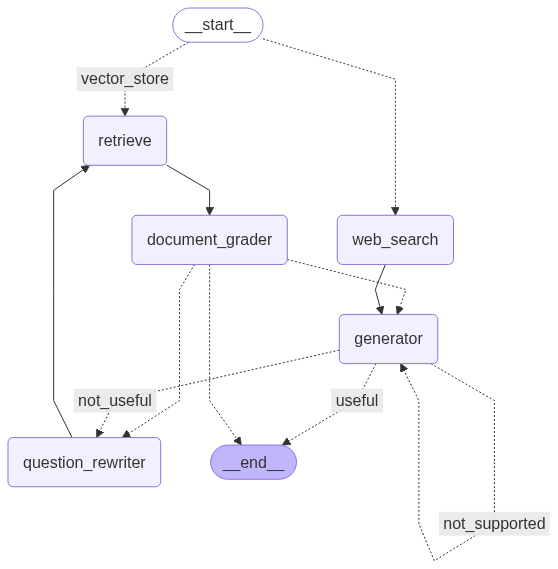

In [178]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [179]:
app.invoke({"question":"what is machine learning?"})

---ROUTE QUERY---
---ROUTE QUESTION TO VECTORSTORE---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE---
---GRADE: DOCUMENT IRRELEVANT---
---GRADE: DOCUMENT IRRELEVANT---
---GRADE: DOCUMENT IRRELEVANT---
---GRADE: DOCUMENT IRRELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUERY, REWRITE QUESTION---
---REWRITE QUESTION---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE---
---GRADE: DOCUMENT IRRELEVANT---
---GRADE: DOCUMENT IRRELEVANT---
---GRADE: DOCUMENT IRRELEVANT---
---GRADE: DOCUMENT IRRELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUERY, REWRITE QUESTION---
---REWRITE QUESTION---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE---
---GRADE: DOCUMENT IRRELEVANT---
---GRADE: DOCUMENT IRRELEVANT---
---GRADE: DOCUMENT IRRELEVANT---
---GRADE: DOCUMENT IRRELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUERY, REWRITE QUESTION---
---REWRITE QUESTION---
---RETRIEVE---
---CHECK DOCUMEN

KeyboardInterrupt: 

In [151]:
app.invoke({"question":"what is Prompt engineering?"})

---ROUTE QUERY---
---ROUTE QUESTION TO VECTORSTORE---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE---
---ENTERING LOOP---
---GRADING---
---GRADE: DOCUMENT RELEVANT---
---GRADING---
---GRADE: DOCUMENT RELEVANT---
---GRADING---
---GRADE: DOCUMENT RELEVANT---
---GRADING---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
DECISION: GENERATE
---GENERATE---
---CHECK HALLUCINATIONS---
---NO HALLUCINATIONS DETECTED---
---CHECK ACCURACY---
---DECISION: GENERARION ADDRESSES QUESTION---


{'question': 'what is Prompt engineering?',
 'documents': [Document(id='db936a15-44a2-422a-ab45-cd6518b70c12', metadata={'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log", 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'language': 'en'}, page_content="Automatic Prompt Design\n\nAugmented Language Models\n\nRetrieval\n\nProg